In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

C:\Users\Maulin\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Maulin\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data = pd.read_csv('train_v9rqX0R.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

In [4]:
data.shape

(8523, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [6]:
data.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

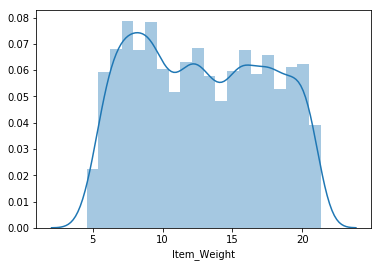

In [7]:
sns.distplot(data['Item_Weight'].dropna())

In [8]:
data.groupby('Item_Fat_Content')['Item_Weight'].mean()

Item_Fat_Content
LF         12.803212
Low Fat    12.953079
Regular    12.705840
low fat    12.563988
reg        12.842642
Name: Item_Weight, dtype: float64

In [9]:
# data['Item_Weight'].interpolate(inplace=True)
data["Item_Weight"] = data.groupby("Item_Fat_Content")['Item_Weight'].apply(lambda x: x.fillna(x.mean()))

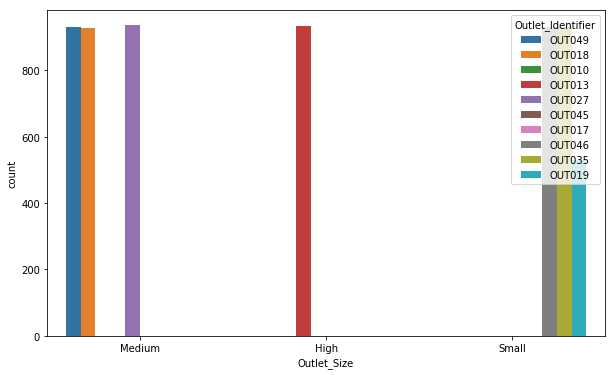

In [10]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
sns.countplot(hue='Outlet_Identifier',x='Outlet_Size',data=data)

In [11]:
data['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

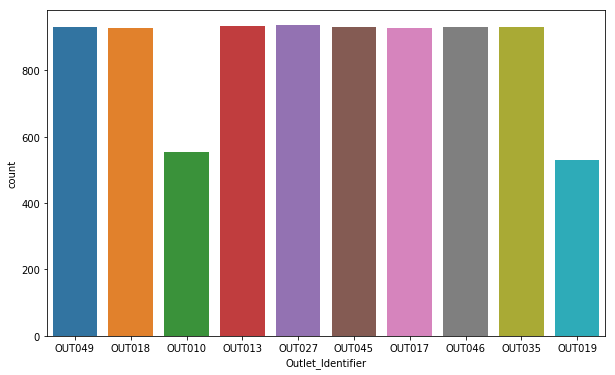

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
sns.countplot(data['Outlet_Identifier'])

In [13]:
from collections import Counter
def filloutletsize(size,identifier):
    Size = []
    for i,j in zip(size,identifier):
        if i is np.nan:
            if j is 'OUT013':
                Size.append('High')
            elif j is 'OUT019' or j is 'OUT035' or j is 'OUT046':
                Size.append('Small')
            else:
                Size.append('Medium')
        else:
            Size.append(i)
    return Size
Counter(filloutletsize(data['Outlet_Size'],data['Outlet_Identifier']))

Counter({'Medium': 5203, 'High': 932, 'Small': 2388})

In [14]:
data['Outlet_Size'] = filloutletsize(data['Outlet_Size'],data['Outlet_Identifier'])
data['Outlet_Size'].value_counts()

Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [16]:
X = data.drop(['Item_Identifier','Item_Outlet_Sales'],axis=1)
y = data['Item_Outlet_Sales']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
549,9.500,Regular,0.035206,Fruits and Vegetables,171.3448,OUT049,1999,Medium,Tier 1,Supermarket Type1
7757,18.000,Low Fat,0.047473,Household,170.5422,OUT045,2002,Medium,Tier 2,Supermarket Type1
764,17.600,Regular,0.076122,Meat,111.7202,OUT046,1997,Small,Tier 1,Supermarket Type1
6867,8.325,Low Fat,0.029845,Fruits and Vegetables,41.6138,OUT045,2002,Medium,Tier 2,Supermarket Type1
2716,12.850,Low Fat,0.137228,Snack Foods,155.5630,OUT046,1997,Small,Tier 1,Supermarket Type1


In [18]:
X_train_cat = X_train[['Item_Weight','Item_Type']]
X_train_num = X_train[['Item_Visibility','Item_MRP']]
X_train_label = X_train[['Outlet_Identifier','Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type']]
X_test_cat = X_test[['Item_Weight','Item_Type']]
X_test_num = X_test[['Item_Visibility','Item_MRP']]
X_test_label = X_test[['Outlet_Identifier','Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [19]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train_cat).toarray()
X_test_cat = ohe.transform(X_test_cat).toarray()

In [20]:
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_num)
X_test_num = sc.transform(X_test_num)

In [21]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
X_train_label['Outlet_Identifier'] = lb.fit_transform(X_train_label['Outlet_Identifier'])
X_test_label['Outlet_Identifier'] = lb.transform(X_test_label['Outlet_Identifier'])
X_train_label['Item_Fat_Content'] = lb.fit_transform(X_train_label['Item_Fat_Content'])
X_test_label['Item_Fat_Content'] = lb.transform(X_test_label['Item_Fat_Content'])
X_train_label['Outlet_Size'] = lb.fit_transform(X_train_label['Outlet_Size'])
X_test_label['Outlet_Size'] = lb.transform(X_test_label['Outlet_Size'])
X_train_label['Outlet_Location_Type'] = lb.fit_transform(X_train_label['Outlet_Location_Type'])
X_test_label['Outlet_Location_Type'] = lb.transform(X_test_label['Outlet_Location_Type'])
X_train_label['Outlet_Type'] = lb.fit_transform(X_train_label['Outlet_Type'])
X_test_label['Outlet_Type'] = lb.transform(X_test_label['Outlet_Type'])

In [22]:
X_train_final = np.hstack((X_train_cat,X_train_num,X_train_label))
X_test_final = np.hstack((X_test_cat,X_test_num,X_test_label))

In [23]:
lrmodel = LinearRegression()
lrmodel.fit(X_train_final,y_train)
print("Training score",lrmodel.score(X_train_final,y_train))
print("Test score",lrmodel.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,lrmodel.predict(X_test_final))))

Training score 0.5340750281338755
Test score -1.936270057590823e+18
root mean squared error 2294062784105.547


In [24]:
ridgemodel = Ridge(alpha=100)
ridgemodel.fit(X_train_final,y_train)
print("Training score",ridgemodel.score(X_train_final,y_train))
print("Test score",ridgemodel.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,ridgemodel.predict(X_test_final))))

Training score 0.5134416355588531
Test score 0.5281711524229824
root mean squared error 1132.4383799044424


In [25]:
knnmodel = KNeighborsRegressor(n_neighbors=30)
knnmodel.fit(X_train_final,y_train)
print("Training score",knnmodel.score(X_train_final,y_train))
print("Test score",knnmodel.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,knnmodel.predict(X_test_final))))

Training score 0.5952063800271268
Test score 0.597645719780705
root mean squared error 1045.7470486743728


In [31]:
dtmodel = DecisionTreeRegressor(max_depth=5)
dtmodel.fit(X_train_final,y_train)
print("Training score",dtmodel.score(X_train_final,y_train))
print("Test score",dtmodel.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,dtmodel.predict(X_test_final))))

Training score 0.6006620548477031
Test score 0.6115084466699748
root mean squared error 1027.5740426287746


In [33]:
rfmodel = RandomForestRegressor(n_estimators=2200,max_depth=5,max_samples=0.9)
rfmodel.fit(X_train_final,y_train)
print("Training score",rfmodel.score(X_train_final,y_train))
print("Test score",rfmodel.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,rfmodel.predict(X_test_final))))

Training score 0.6079536754339485
Test score 0.6167677825781859
root mean squared error 1020.5947753715196


In [46]:
param_grid = {'n_estimators':[50,100,200,500],
              'max_depth':[5,10,15,20,25],
              'criterion':['friedman_mse','mse'],
              'max_samples':[0.3,0.5,0.8]}
rf = RandomForestRegressor()
rf_regressor = GridSearchCV(rf,param_grid,cv=3)
rf_regressor.fit(X_train_final,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'max_samples': [0.3, 0.5, 0.8],
                         'n_estimators': [50, 100, 200, 500]})

In [47]:
print("Training score",rf_regressor.score(X_train_final,y_train))
print("Test score",rf_regressor.score(X_test_final,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,rf_regressor.predict(X_test_final))))
print('best paramater',rf_regressor.best_params_)

Training score 0.6097696328276299
Test score 0.603507480806462
root mean squared error 1045.9033680222162
best paramater {'criterion': 'friedman_mse', 'max_depth': 5, 'max_samples': 0.3, 'n_estimators': 200}


In [46]:
X_train_final = pd.DataFrame(X_train_final)
X_test_final = pd.DataFrame(X_test_final)

In [48]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestRegressor(criterion = 'friedman_mse', max_depth = 5, max_samples= 0.3, n_estimators =  200))
sel.fit(X_train_final, y_train)
sel.get_support()
selected_feat= X_train_final.columns[(sel.get_support())]
selected_feat

Int64Index([433, 434, 439], dtype='int64')

In [54]:
train_temp = X_train_final[[443, 448, 463, 466, 467, 468]]
test_temp = X_test_final[[443, 448, 463, 466, 467, 468]]
test_temp.shape

(2131, 6)

In [55]:
rfmodel = RandomForestRegressor(n_estimators=200,max_depth=5,max_samples=0.3)
rfmodel.fit(train_temp,y_train)
print("Training score",rfmodel.score(train_temp,y_train))
print("Test score",rfmodel.score(test_temp,y_test))
print('root mean squared error',np.sqrt(mean_squared_error(y_test,rfmodel.predict(test_temp))))

Training score 0.6087717942296624
Test score 0.6028681110945422
root mean squared error 1046.746321586044
